In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import os
from collections import Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import TomekLinks
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")
sns.set_context("notebook", font_scale=1.2)

np.random.seed(42)

In [68]:
# =========================
# 1. LOAD DATA
# =========================
air_quality_data = load_and_prepare_air_quality_data('dataset/ispu_dki_all.csv')


# =========================
# 2. REMOVE UNWANTED CATEGORY
# =========================
air_quality_data = air_quality_data[air_quality_data['categori'] != 'TIDAK ADA DATA']


# =========================
# 3. DROP MISSING VALUES
# =========================
pollutant_features = ['pm10', 'pm25', 'so2', 'co', 'o3', 'no2']
air_quality_data = air_quality_data.dropna(subset=pollutant_features)

Mengload dataset dari file: dataset/ispu_dki_all.csv
=== INFORMASI DATASET ===
Jumlah baris: 5538
Jumlah kolom: 11

Nama kolom:
['tanggal', 'stasiun', 'pm25', 'pm10', 'so2', 'co', 'o3', 'no2', 'max', 'critical', 'categori']

Tipe data per kolom:
tanggal      object
stasiun      object
pm25        float64
pm10        float64
so2         float64
co          float64
o3          float64
no2         float64
max         float64
critical     object
categori     object
dtype: object

Contoh data (5 baris pertama):
      tanggal             stasiun  pm25  pm10  so2    co    o3   no2   max  \
0  2010-01-01  DKI1 (Bunderan HI)   NaN  60.0  4.0  73.0  27.0  14.0  73.0   
1  2010-01-02  DKI1 (Bunderan HI)   NaN  32.0  2.0  16.0  33.0   9.0  33.0   
2  2010-01-03  DKI1 (Bunderan HI)   NaN  27.0  2.0  19.0  20.0   9.0  27.0   
3  2010-01-04  DKI1 (Bunderan HI)   NaN  22.0  2.0  16.0  15.0   6.0  22.0   
4  2010-01-05  DKI1 (Bunderan HI)   NaN  25.0  2.0  17.0  15.0   8.0  25.0   

  critical categori

In [69]:

# =========================
# 4. LABEL ENCODING
# =========================
label_encoder = LabelEncoder()
air_quality_data['categori_encoded'] = label_encoder.fit_transform(air_quality_data['categori'])


# =========================
# 5. REMOVE RARE CLASSES (<2)
# =========================
counts = air_quality_data['categori_encoded'].value_counts()
valid_classes = counts[counts >= 2].index
air_quality_data = air_quality_data[air_quality_data['categori_encoded'].isin(valid_classes)]


# =========================
# 6. EXTRACT DATE FEATURES
# =========================
air_quality_data['tanggal'] = pd.to_datetime(air_quality_data['tanggal'])
air_quality_data['bulan'] = air_quality_data['tanggal'].dt.month
air_quality_data['hari'] = air_quality_data['tanggal'].dt.day
air_quality_data['jam'] = air_quality_data['tanggal'].dt.hour
air_quality_data['hari_minggu'] = air_quality_data['tanggal'].dt.dayofweek


# =========================
# 7. ADD METEOROLOGICAL FEATURES (DUMMY)
# =========================
air_quality_data['suhu'] = np.random.normal(28, 5, len(air_quality_data)).clip(20, 40)
air_quality_data['kelembaban'] = np.random.normal(70, 15, len(air_quality_data)).clip(40, 100)
air_quality_data['kecepatan_angin'] = np.random.normal(2.5, 1, len(air_quality_data)).clip(0.5, 10)

air_quality_data['heat_index'] = 0.5 * (
    air_quality_data['suhu'] + 61 +
    ((air_quality_data['suhu'] - 68) * 1.2) +
    (air_quality_data['kelembaban'] * 0.094)
)


# =========================
# 8. FINAL FEATURE SET
# =========================
features = [
    'pm25', 'pm10', 'so2', 'co', 'o3', 'no2',
    'suhu', 'kelembaban', 'kecepatan_angin', 'heat_index',
    'bulan', 'hari', 'jam', 'hari_minggu'
]

X = air_quality_data[features]
y = air_quality_data['categori_encoded']


# =========================
# 9. SCALING
# =========================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)


# =========================
# 10. TRAIN-TEST SPLIT
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)


In [70]:

# =========================
# 11. HANDLE IMBALANCE (SMOTE-ENN + TOMEK)
# =========================
class_ratio = y_train.value_counts().min() / y_train.value_counts().max()
need_smote = class_ratio < 0.5

if need_smote:
    smote_enn = SMOTEENN(
        random_state=42,
        smote=SMOTE(k_neighbors=1)  # ↓↓↓ solusi utama
    )
    tomek = TomekLinks()

    X_res, y_res = smote_enn.fit_resample(X_train, y_train)
    X_res, y_res = tomek.fit_resample(X_res, y_res)

    X_train_balanced = X_res
    y_train_balanced = y_res


In [71]:
print("\n=== ANALISIS KETIDAKSEIMBANGAN DATA ===")
print("\nDistribusi kelas sebelum penanganan imbalance:")
class_counts = pd.Series(y_train).value_counts()
for class_idx, count in class_counts.items():
    class_name = label_encoder.inverse_transform([class_idx])[0]
    percentage = count / len(y_train) * 100
    print(f"Kelas '{class_name}': {count} sampel ({percentage:.1f}%)")


=== ANALISIS KETIDAKSEIMBANGAN DATA ===

Distribusi kelas sebelum penanganan imbalance:
Kelas 'SEDANG': 581 sampel (65.9%)
Kelas 'TIDAK SEHAT': 276 sampel (31.3%)
Kelas 'BAIK': 23 sampel (2.6%)
Kelas 'SANGAT TIDAK SEHAT': 2 sampel (0.2%)


In [72]:
print("\n=== PREPROCESSING DATA SESUAI FORMAT DATASET ===")
print("\nMelakukan penanganan missing values...")

if 'pm25' in air_quality_data.columns:
    pm25_mean = air_quality_data['pm25'].mean()
    if np.isnan(pm25_mean):
        pm25_mean = 50.0
    air_quality_data['pm25'] = air_quality_data['pm25'].fillna(pm25_mean)
    print(f"Missing values di kolom pm25 diisi dengan mean: {pm25_mean:.2f}")


from sklearn.preprocessing import LabelEncoder

print("\nMelakukan transformasi kolom 'categori'...")
label_encoder = LabelEncoder()
air_quality_data['categori_encoded'] = label_encoder.fit_transform(air_quality_data['categori'])
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Pemetaan kategori:")
for cat, code in category_mapping.items():
    print(f"'{cat}' -> {code}")


air_quality_data['tanggal'] = pd.to_datetime(air_quality_data['tanggal'])
air_quality_data['bulan'] = air_quality_data['tanggal'].dt.month
air_quality_data['hari'] = air_quality_data['tanggal'].dt.day
air_quality_data['jam'] = air_quality_data['tanggal'].dt.hour
air_quality_data['hari_minggu'] = air_quality_data['tanggal'].dt.dayofweek


air_quality_data['stasiun_name'] = air_quality_data['stasiun'].str.split('(').str[0].str.strip()

print("\nInformasi stasiun unik:")
print(air_quality_data['stasiun_name'].unique())



print("\nMenambahkan fitur meteorologi dummy...")


air_quality_data['suhu'] = np.random.normal(28, 5, len(air_quality_data))
air_quality_data['suhu'] = air_quality_data['suhu'].clip(20, 40)


air_quality_data['kelembaban'] = np.random.normal(70, 15, len(air_quality_data))
air_quality_data['kelembaban'] = air_quality_data['kelembaban'].clip(40, 100)


air_quality_data['kecepatan_angin'] = np.random.normal(2.5, 1, len(air_quality_data))
air_quality_data['kecepatan_angin'] = air_quality_data['kecepatan_angin'].clip(0.5, 10)


air_quality_data['heat_index'] = 0.5 * (
    air_quality_data['suhu'] + 61.0 + 
    ((air_quality_data['suhu'] - 68.0) * 1.2) + 
    (air_quality_data['kelembaban'] * 0.094)
)

print("\nFitur meteorologi dummy ditambahkan!")



features = [
    'pm25', 'pm10', 'so2', 'co', 'o3', 'no2', 
    'suhu', 'kelembaban', 'kecepatan_angin', 'heat_index',
    'bulan', 'hari', 'jam', 'hari_minggu'
]


available_features = [f for f in features if f in air_quality_data.columns]
print(f"\nFitur yang tersedia untuk model: {available_features}")

X = air_quality_data[available_features]
y = air_quality_data['categori_encoded']


from sklearn.preprocessing import StandardScaler

print("\nMelakukan normalisasi data...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=available_features)


# Hitung jumlah sampel per kelas
class_counts = air_quality_data['categori_encoded'].value_counts()

# Hanya pertahankan kelas dengan minimal 2 sampel
valid_classes = class_counts[class_counts >= 2].index
air_quality_data_filtered = air_quality_data[air_quality_data['categori_encoded'].isin(valid_classes)]

print(f"\nKelas setelah filter (minimal 2 sampel):")
for cat, code in category_mapping.items():
    if code in valid_classes:
        count = (air_quality_data_filtered['categori_encoded'] == code).sum()
        print(f"'{cat}' -> {code} ({count} sampel)")

# Update X dan y dengan data yang sudah difilter
X = air_quality_data_filtered[available_features]
y = air_quality_data_filtered['categori_encoded']

# Normalisasi ulang
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=available_features)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, 
    test_size=0.3, 
    random_state=42,
    stratify=y  # Sekarang aman karena semua kelas punya ≥2 sampel
)

print(f"\nUkuran dataset training: {X_train.shape[0]} sampel")
print(f"Ukuran dataset testing: {X_test.shape[0]} sampel")



=== PREPROCESSING DATA SESUAI FORMAT DATASET ===

Melakukan penanganan missing values...
Missing values di kolom pm25 diisi dengan mean: 87.87

Melakukan transformasi kolom 'categori'...
Pemetaan kategori:
'BAIK' -> 0
'SANGAT TIDAK SEHAT' -> 1
'SEDANG' -> 2
'TIDAK SEHAT' -> 3

Informasi stasiun unik:
['DKI2' 'DKI3' 'DKI5' 'DKI4' 'DKI1' nan]

Menambahkan fitur meteorologi dummy...

Fitur meteorologi dummy ditambahkan!

Fitur yang tersedia untuk model: ['pm25', 'pm10', 'so2', 'co', 'o3', 'no2', 'suhu', 'kelembaban', 'kecepatan_angin', 'heat_index', 'bulan', 'hari', 'jam', 'hari_minggu']

Melakukan normalisasi data...

Kelas setelah filter (minimal 2 sampel):
'BAIK' -> 0 (33 sampel)
'SANGAT TIDAK SEHAT' -> 1 (3 sampel)
'SEDANG' -> 2 (830 sampel)
'TIDAK SEHAT' -> 3 (395 sampel)

Ukuran dataset training: 882 sampel
Ukuran dataset testing: 379 sampel



=== ANALISIS KETIDAKSEIMBANGAN DATA ===

Distribusi kelas sebelum penanganan imbalance:
Kelas 'SEDANG': 830 sampel (65.8%)
Kelas 'TIDAK SEHAT': 395 sampel (31.3%)
Kelas 'BAIK': 33 sampel (2.6%)
Kelas 'SANGAT TIDAK SEHAT': 3 sampel (0.2%)


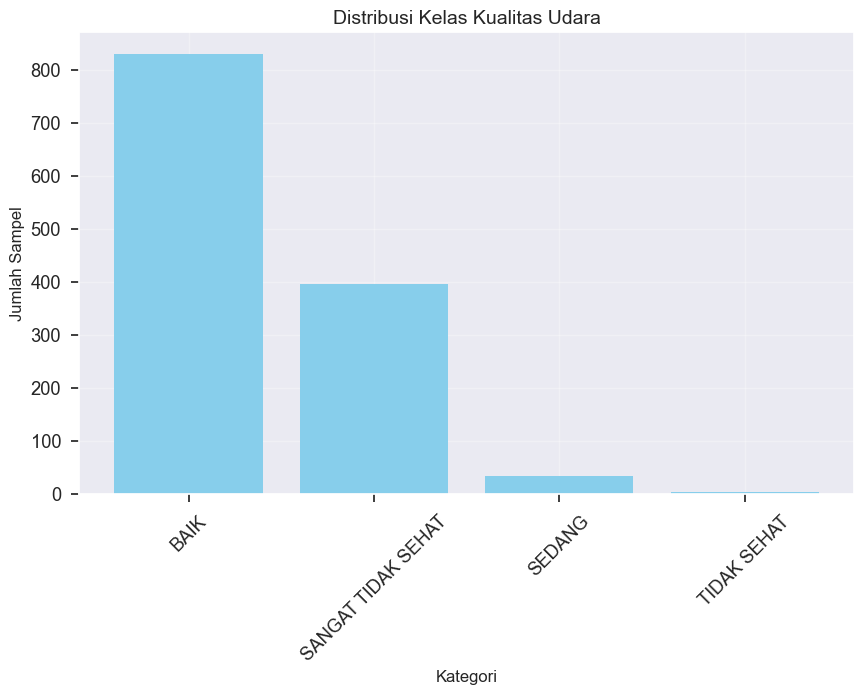


=== PENANGANAN DATA TIDAK SEIMBANG ===
Data tidak seimbang, menerapkan teknik SMOTE-ENN + Tomek Links...
Setelah SMOTE-ENN: Counter({0: 581, 1: 581, 3: 500, 2: 373})
Setelah Tomek Links: Counter({0: 581, 1: 581, 3: 500, 2: 373})

Distribusi kelas setelah penanganan imbalance:
Kelas 'BAIK': 581 sampel (28.6%)
Kelas 'SANGAT TIDAK SEHAT': 581 sampel (28.6%)
Kelas 'SEDANG': 373 sampel (18.3%)
Kelas 'TIDAK SEHAT': 500 sampel (24.6%)


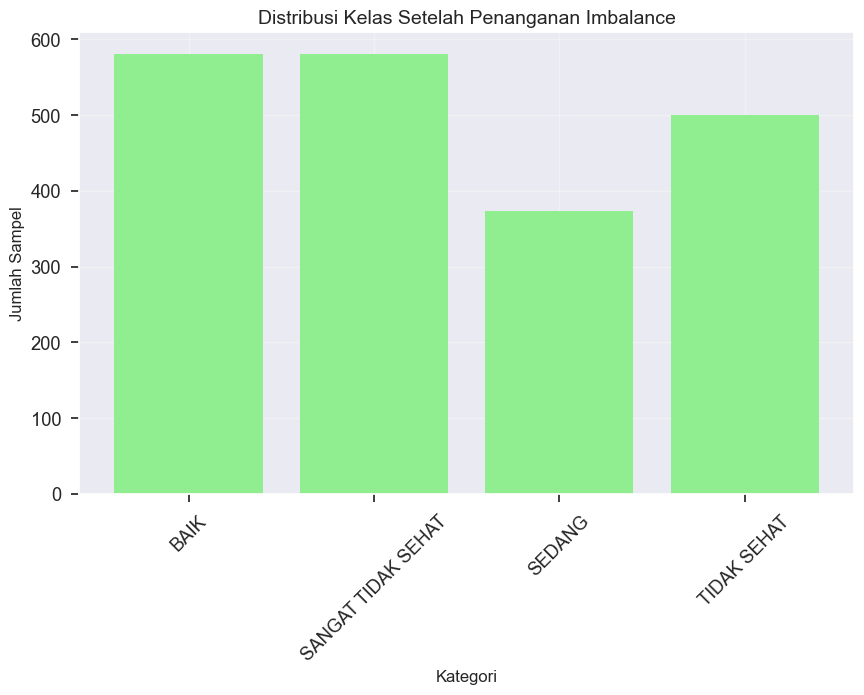

In [73]:
# =========================
# 10. ANALISIS KETIDAKSEIMBANGAN DATA
# =========================
print("\n=== ANALISIS KETIDAKSEIMBANGAN DATA ===")
print("\nDistribusi kelas sebelum penanganan imbalance:")

class_counts = pd.Series(y).value_counts()

for class_idx, count in class_counts.items():
    class_name = label_encoder.inverse_transform([class_idx])[0]
    percentage = count / len(y) * 100
    print(f"Kelas '{class_name}': {count} sampel ({percentage:.1f}%)")

plt.figure(figsize=(10, 6))
class_names = [label_encoder.inverse_transform([i])[0] for i in sorted(class_counts.index)]
plt.bar(class_names, class_counts.values, color='skyblue')
plt.title('Distribusi Kelas Kualitas Udara', fontsize=14)
plt.xlabel('Kategori', fontsize=12)
plt.ylabel('Jumlah Sampel', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.savefig('class_distribution_before.png', dpi=300, bbox_inches='tight')
plt.show()


# =========================
# 11. PENANGANAN IMBALANCE (SMOTE-ENN + TOMEK)
# =========================
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from imblearn.combine import SMOTEENN
from collections import Counter

print("\n=== PENANGANAN DATA TIDAK SEIMBANG ===")

needs_smote = False
if len(class_counts) > 1:
    min_class_ratio = class_counts.min() / class_counts.max()
    if min_class_ratio < 0.5:
        needs_smote = True

if needs_smote:
    print("Data tidak seimbang, menerapkan teknik SMOTE-ENN + Tomek Links...")

    smote_enn = SMOTEENN(
        sampling_strategy='auto',
        random_state=42,
        smote=SMOTE(
            sampling_strategy='auto',
            random_state=42,
            k_neighbors=1   # ← FIX WAJIB
        ),
        enn=EditedNearestNeighbours(sampling_strategy='all')
    )

    tomek = TomekLinks(sampling_strategy='all')

    # SMOTE + ENN
    X_res, y_res = smote_enn.fit_resample(X_train, y_train)
    print(f"Setelah SMOTE-ENN: {Counter(y_res)}")

    # Tomek Links
    X_res, y_res = tomek.fit_resample(X_res, y_res)
    print(f"Setelah Tomek Links: {Counter(y_res)}")

    # simpan hasil final
    X_train_balanced = X_res
    y_train_balanced = y_res

    print("\nDistribusi kelas setelah penanganan imbalance:")
    balanced_counts = Counter(y_train_balanced)

    for class_idx, count in balanced_counts.items():
        class_name = label_encoder.inverse_transform([class_idx])[0]
        percentage = count / len(y_train_balanced) * 100
        print(f"Kelas '{class_name}': {count} sampel ({percentage:.1f}%)")

    # Plot distribusi setelah balancing
    plt.figure(figsize=(10, 6))
    balanced_class_names = [
        label_encoder.inverse_transform([i])[0] 
        for i in sorted(balanced_counts.keys())
    ]
    plt.bar(
        balanced_class_names,
        [balanced_counts[i] for i in sorted(balanced_counts.keys())],
        color='lightgreen'
    )
    plt.title('Distribusi Kelas Setelah Penanganan Imbalance', fontsize=14)
    plt.xlabel('Kategori', fontsize=12)
    plt.ylabel('Jumlah Sampel', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.savefig('class_distribution_after.png', dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("Data seimbang, tidak perlu teknik khusus.")
    X_train_balanced = X_train
    y_train_balanced = y_train



=== PEMODELAN DENGAN DECISION TREE ===

Membuat model Decision Tree...
Training selesai dalam 0.03 detik!

Akurasi model Decision Tree: 0.9578 (95.78%)

Laporan Klasifikasi:
                    precision    recall  f1-score   support

              BAIK       0.56      0.50      0.53        10
SANGAT TIDAK SEHAT       0.00      0.00      0.00         1
            SEDANG       0.97      0.97      0.97       249
       TIDAK SEHAT       0.97      0.97      0.97       119

          accuracy                           0.96       379
         macro avg       0.62      0.61      0.62       379
      weighted avg       0.96      0.96      0.96       379



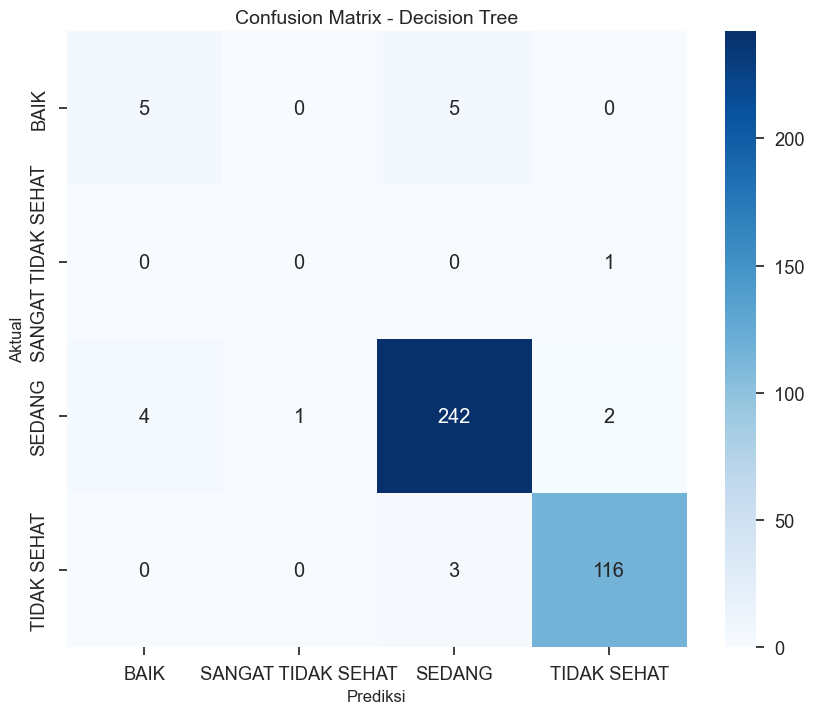

In [74]:
print("\n=== PEMODELAN DENGAN DECISION TREE ===")

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import time


print("\nMembuat model Decision Tree...")
dt_model = DecisionTreeClassifier(random_state=42)


start_time = time.time()
dt_model.fit(X_train_balanced, y_train_balanced)
training_time = time.time() - start_time
print(f"Training selesai dalam {training_time:.2f} detik!")


y_pred = dt_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"\nAkurasi model Decision Tree: {accuracy:.4f} ({accuracy*100:.2f}%)")


print("\nLaporan Klasifikasi:")
target_names = label_encoder.inverse_transform(np.unique(y))
print(classification_report(y_test, y_pred, target_names=target_names))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, 
            yticklabels=target_names)
plt.title('Confusion Matrix - Decision Tree', fontsize=14)
plt.xlabel('Prediksi', fontsize=12)
plt.ylabel('Aktual', fontsize=12)
plt.savefig('confusion_matrix_dt.png', dpi=300, bbox_inches='tight')
plt.show()


In [75]:




print("\n=== OPTIMASI HYPERPARAMETER DECISION TREE ===")


param_grid = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}



from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=min(3, len(np.unique(y_train_balanced))), shuffle=True, random_state=42)

print("\nMemulai Grid Search untuk optimasi hyperparameter...")
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=cv_strategy,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)


start_time = time.time()
grid_search.fit(X_train_balanced, y_train_balanced)
optimization_time = time.time() - start_time
print(f"Optimasi selesai dalam {optimization_time:.2f} detik!")


print("\nHasil Optimasi Hyperparameter:")
print(f"Parameter terbaik: {grid_search.best_params_}")
print(f"Skor terbaik: {grid_search.best_score_:.4f}")


best_dt_model = grid_search.best_estimator_


y_pred_best = best_dt_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"\nAkurasi model Decision Tree optimal: {accuracy_best:.4f} ({accuracy_best*100:.2f}%)")


print("\nLaporan Klasifikasi Model Optimal:")
print(classification_report(y_test, y_pred_best, target_names=target_names))


=== OPTIMASI HYPERPARAMETER DECISION TREE ===

Memulai Grid Search untuk optimasi hyperparameter...
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Optimasi selesai dalam 10.93 detik!

Hasil Optimasi Hyperparameter:
Parameter terbaik: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Skor terbaik: 0.9906

Akurasi model Decision Tree optimal: 0.9736 (97.36%)

Laporan Klasifikasi Model Optimal:
                    precision    recall  f1-score   support

              BAIK       0.67      0.80      0.73        10
SANGAT TIDAK SEHAT       0.00      0.00      0.00         1
            SEDANG       0.99      0.98      0.98       249
       TIDAK SEHAT       0.98      0.99      0.98       119

          accuracy                           0.97       379
         macro avg       0.66      0.69      0.67       379
      weighted avg       0.97      0.97      0.97       379




=== VISUALISASI DECISION TREE ===


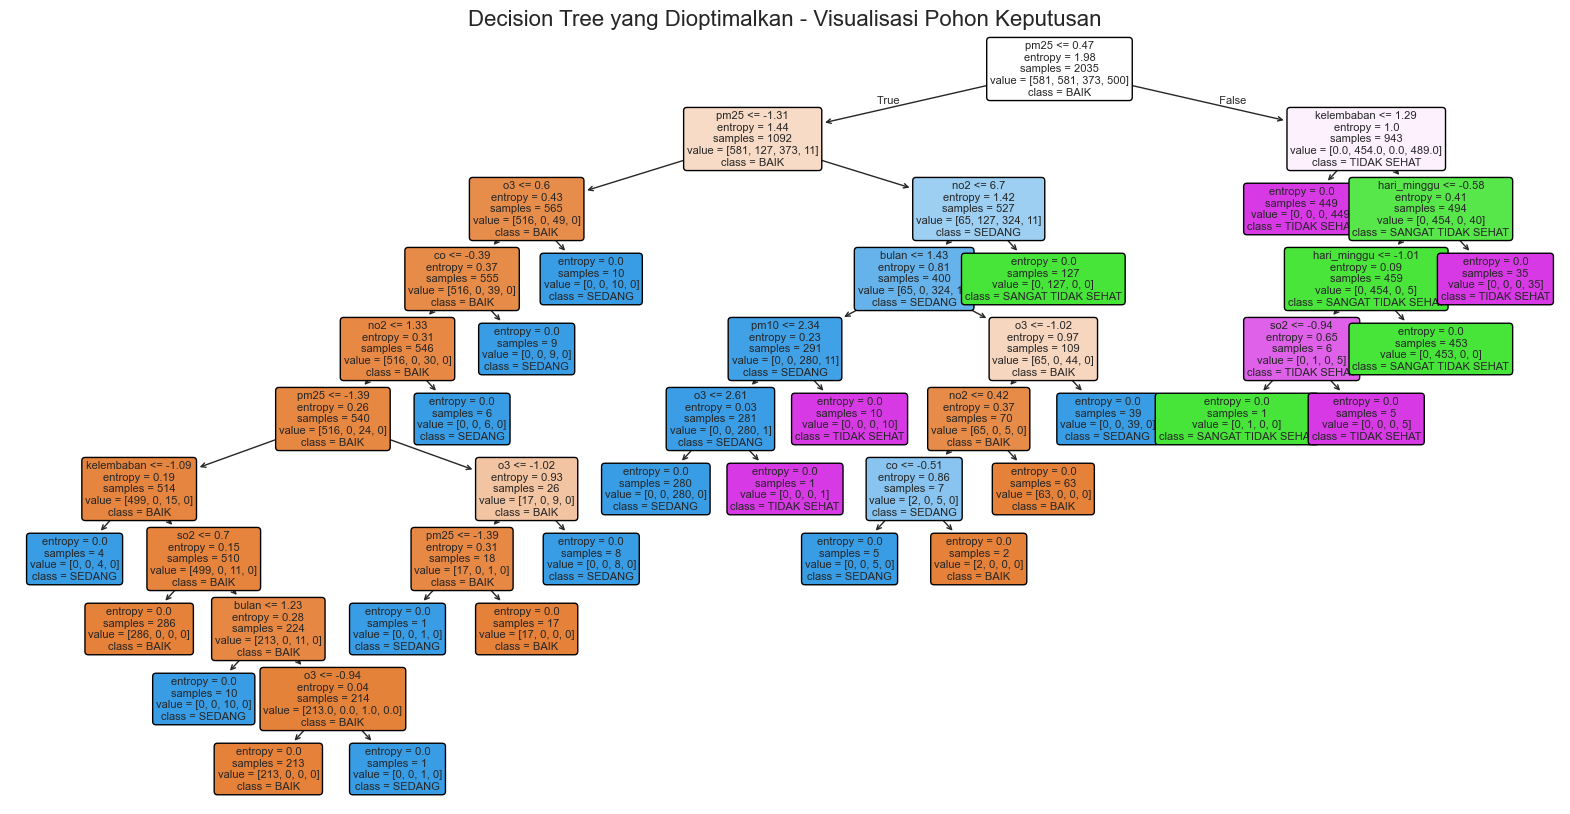


=== PENTINGNYA FITUR (FEATURE IMPORTANCE) ===
            Feature  Importance
0              pm25    0.527433
7        kelembaban    0.189455
5               no2    0.115669
10            bulan    0.051264
13      hari_minggu    0.048787
4                o3    0.038289
1              pm10    0.014396
3                co    0.010441
2               so2    0.004267
6              suhu    0.000000
9        heat_index    0.000000
8   kecepatan_angin    0.000000
11             hari    0.000000
12              jam    0.000000


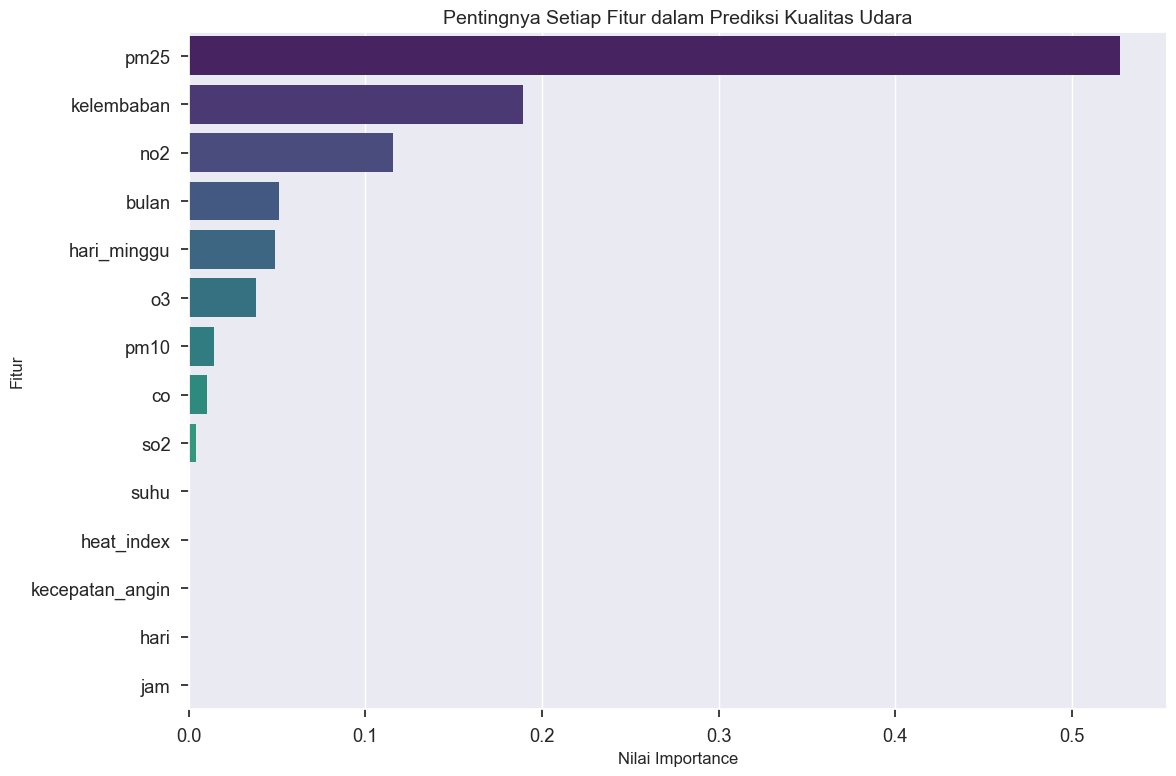

In [76]:


print("\n=== VISUALISASI DECISION TREE ===")

from sklearn.tree import plot_tree


plt.figure(figsize=(20, 10))
plot_tree(
    best_dt_model, 
    filled=True, 
    feature_names=available_features,
    class_names=target_names,
    rounded=True,
    proportion=False,
    precision=2,
    fontsize=8
)
plt.title('Decision Tree yang Dioptimalkan - Visualisasi Pohon Keputusan', fontsize=16)
plt.savefig('decision_tree_visualization.png', dpi=300, bbox_inches='tight')
plt.show()


feature_importance = pd.DataFrame({
    'Feature': available_features,
    'Importance': best_dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n=== PENTINGNYA FITUR (FEATURE IMPORTANCE) ===")
print(feature_importance)


plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Pentingnya Setiap Fitur dalam Prediksi Kualitas Udara', fontsize=14)
plt.xlabel('Nilai Importance', fontsize=12)
plt.ylabel('Fitur', fontsize=12)
plt.tight_layout()
plt.savefig('feature_importance_dt.png', dpi=300, bbox_inches='tight')
plt.show()


In [77]:





print("\n=== MENYIMPAN MODEL DAN ARTIFAK ===")


os.makedirs('model_artifacts', exist_ok=True)


model_path = 'model_artifacts/air_quality_dt_model.pkl'
joblib.dump(best_dt_model, model_path)
print(f"Model terbaik disimpan di: {model_path}")


scaler_path = 'model_artifacts/feature_scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler disimpan di: {scaler_path}")


encoder_path = 'model_artifacts/label_encoder.pkl'
joblib.dump(label_encoder, encoder_path)
print(f"Label encoder disimpan di: {encoder_path}")


features_path = 'model_artifacts/model_features.txt'
with open(features_path, 'w') as f:
    for feature in available_features:
        f.write(f"{feature}\n")
print(f"Daftar fitur disimpan di: {features_path}")



=== MENYIMPAN MODEL DAN ARTIFAK ===
Model terbaik disimpan di: model_artifacts/air_quality_dt_model.pkl
Scaler disimpan di: model_artifacts/feature_scaler.pkl
Label encoder disimpan di: model_artifacts/label_encoder.pkl
Daftar fitur disimpan di: model_artifacts/model_features.txt


In [79]:





print("\n=== CONTOH PREDIKSI UNTUK DATA BARU ===")


sample_data = {
    'pm10': [75.0],
    'pm25': [55.0],
    'so2': [20.0],
    'co': [35.0],
    'o3': [40.0],
    'no2': [30.0],
    'suhu': [28.5],
    'kelembaban': [65],
    'kecepatan_angin': [2.5],
    'heat_index': [30.2],
    'bulan': [6],
    'hari': [15],
    'jam': [14],
    'hari_minggu': [2]
}


sample_df = pd.DataFrame({k: v for k, v in sample_data.items() if k in available_features})

# perbaiki urutan kolom
sample_df = sample_df[available_features]




sample_scaled = scaler.transform(sample_df)


sample_prediction = best_dt_model.predict(sample_scaled)
sample_proba = best_dt_model.predict_proba(sample_scaled)


predicted_category = label_encoder.inverse_transform(sample_prediction)[0]
print(f"Prediksi kategori untuk data contoh: {predicted_category}")
print("Probabilitas untuk setiap kategori:")
for i, category in enumerate(target_names):
    print(f"  {category}: {sample_proba[0][i]*100:.1f}%")


def get_health_recommendation(category):
    recommendations = {
        'BAIK': [
            "Kualitas udara sangat baik untuk aktivitas luar ruangan",
            "Aman bagi semua kelompok usia",
            "Tidak diperlukan tindakan perlindungan khusus"
        ],
        'SEDANG': [
            "Kualitas udara masih dapat diterima",
            "ℹOrang yang sangat sensitif terhadap polusi udara sebaiknya mengurangi aktivitas berat di luar ruangan",
            "Kelompok umum umumnya tidak terpengaruh"
        ],
        'TIDAK SEHAT': [
            "Anak-anak, lansia, dan orang dengan penyakit pernapasan sebaiknya mengurangi aktivitas luar ruangan",
            "Pertimbangkan penggunaan masker saat berada di luar ruangan",
            "Tutup jendela untuk mencegah masuknya polutan"
        ],
        'SANGAT TIDAK SEHAT': [
            "Hindari aktivitas berat di luar ruangan",
            "Gunakan masker N95 saat harus keluar rumah",
            "Kurangi waktu di luar ruangan, terutama di siang hari",
            "Lindungi kelompok rentan (anak-anak, lansia, penderita asma)"
        ],
        'BERBAHAYA': [
            "KEADAAN DARURAT - Hindari semua aktivitas di luar ruangan",
            "Cari pertolongan medis jika mengalami gejala pernapasan",
            "Tutup semua jendela dan ventilasi",
            "Hubungi otoritas lingkungan setempat untuk informasi darurat"
        ]
    }
    return recommendations.get(category, ["Tidak ada rekomendasi spesifik untuk kategori ini"])


print(f"\nRekomendasi Kesehatan untuk kategori '{predicted_category}':")
for rec in get_health_recommendation(predicted_category):
    print(f"- {rec}")

print("\n=== PROSES SELESAI ===")
print("Model siap untuk deployment aplikasi web!")


=== CONTOH PREDIKSI UNTUK DATA BARU ===
Prediksi kategori untuk data contoh: SEDANG
Probabilitas untuk setiap kategori:
  BAIK: 0.0%
  SANGAT TIDAK SEHAT: 0.0%
  SEDANG: 100.0%
  TIDAK SEHAT: 0.0%

Rekomendasi Kesehatan untuk kategori 'SEDANG':
- Kualitas udara masih dapat diterima
- ℹOrang yang sangat sensitif terhadap polusi udara sebaiknya mengurangi aktivitas berat di luar ruangan
- Kelompok umum umumnya tidak terpengaruh

=== PROSES SELESAI ===
Model siap untuk deployment aplikasi web!
